## HW5 logistic_regression（逻辑回归作业练习）

### <font color=brown> 本次作业包括两个练习</font>
### 练习1: 使用逻辑回归模型来对学生是否能被大学录取进行预测。
### 已知数据集中包含两次测试成绩exam1 和 exam2，以及是否被录取的标记 admitted。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report #这个包是评价报告
%matplotlib inline
plt.style.use('fivethirtyeight')

### 1.1 准备数据

In [2]:
print("")  #  双引号内替换成你的学号和姓名
data = pd.read_csv('hw5data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()#看前五行

191250186 余东骏


,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


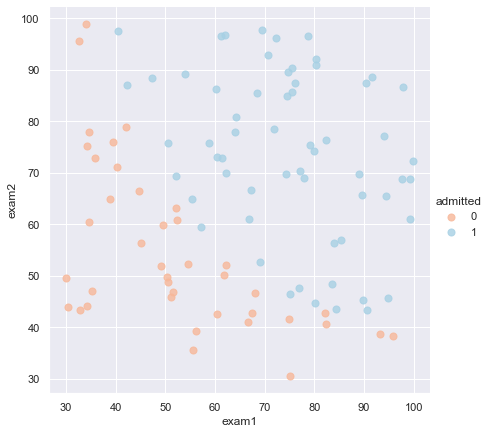

In [4]:
# 关于 SeaBorn 画图，可参考：https://www.jianshu.com/p/5ff47c7d0cc9

sns.set(context="notebook", style="darkgrid", color_codes=False, palette=sns.color_palette("RdBu", 2))

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()  #看一下数据的样子

In [5]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))}) # ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)            # 合并数据，根据列合并
    return data.iloc[:, :-1].values                 # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])                # df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())  # 特征缩放

In [6]:
X = get_X(data)
print(X.shape)
# print(X)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


### 1.2 sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [7]:
## 实现sigmoid 函数
def sigmoid(z):
    return 1/(1+np.exp(-z))                              ## 补充YOUR_CODE处的代码

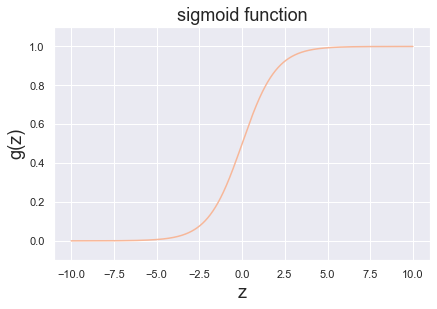

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01))) 
# print(type(sigmoid(np.arange(-10, 10, step=0.01)))) # 这里可以直接传一个ndarray进去，出来的也还是一个ndarray
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

### 1.3 cost function(交叉熵代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$


In [9]:
theta = np.zeros(3) # X(m*n) so theta is n*1，
theta

array([0., 0., 0.])

In [10]:
## 实现代价函数 cost
def cost(theta, X, y):
    res = np.sum((-y)@(np.log(sigmoid(X@theta)))-(1-y)@(np.log(1-sigmoid(X@theta))))/ (len(X))
    return res                               ## 补充YOUR_CODE处的代码

# X @ theta与X.dot(theta)等价

In [11]:
cost(theta, X, y)

0.6931471805599452

### 1.4 gradient 函数(梯度函数)
* 梯度计算$\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [12]:
## 实现梯度计算函数 gradient
def gradient(theta, X, y):
    res = (X.T)@((sigmoid(X@theta)-y))/(len(X))
    return res                               ## 补充YOUR_CODE处的代码

In [13]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

### 1.5 拟合参数
* <font color=Brow>这里我们不使用梯度下降法，改用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去计算参数</font>  


In [14]:
import scipy.optimize as opt

In [15]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

In [16]:
print(res)

     fun: 0.2034977015894895
     jac: array([-4.33738420e-07, -2.47262193e-05, -2.84907400e-05])
 message: 'Optimization terminated successfully.'
    nfev: 72
    nhev: 0
     nit: 29
    njev: 199
  status: 0
 success: True
       x: array([-25.16135181,   0.20623186,   0.20147175])


### 1.6 用训练集预测和验证

In [17]:
## 回忆课堂内容，此处的概率如何计算
def predict(x, theta):
    prob = sigmoid(x@theta)                               ## 补充YOUR_CODE处的代码
    return (prob >= 0.5).astype(int)

In [18]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))
## 此处的classification_report函数将根据真值y与预测值y_pred，输出分析报告

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



### 1.7 寻找决策边界

* $\theta^T x = 0$ (一个样本$x$)
* $X \theta = 0$ (所有训练样本$X$)

In [19]:
print(res.x) # this is final theta
res.x[2]

[-25.16135181   0.20623186   0.20147175]


0.2014717480030193

In [20]:
#YOUR_CODE begin
    #此处补充4~5行代码，计算x和y的值，用于绘制决策边界
x = np.arange(0,-res.x[0]/res.x[1], 1)
y = (-res.x[0]-res.x[1]*x)/res.x[2]
print(x)

#YOUR_CODE end

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.]


In [21]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


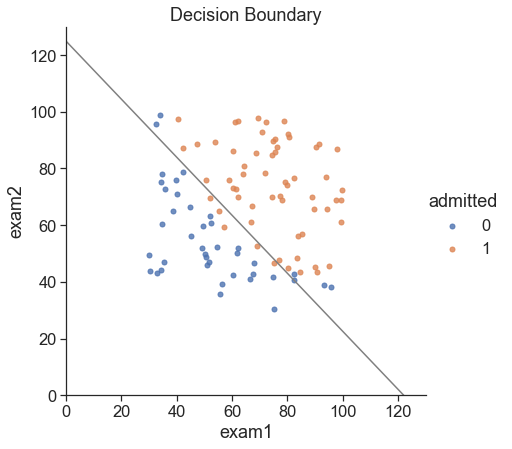

In [22]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           height=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

## 2 正则化逻辑回归
### 练习2: 使用正则化逻辑回归模型来对芯片是否能通过质检进行预测。
### 已知数据集中包含两次检测成绩test1 和 test2，以及是否通过质检的标记 accepted。
### 2.1 准备数据

In [23]:
df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


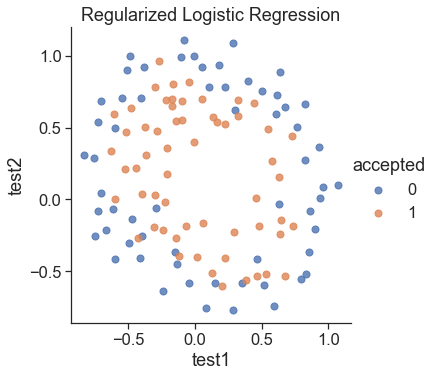

In [24]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           height=5, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

### 2.2 feature mapping（特征映射）

* 我们进行多项式扩展来构造特征
polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```
<img style="float: left;" src="mapped_feature.png">

In [25]:
def feature_mapping(x, y, power, as_ndarray=False):
    #     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)
    #     暴力遍历

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p) #写得很精妙
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).to_numpy()
    else:
        return pd.DataFrame(data)


In [26]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [27]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [28]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


### 2.3 regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [29]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


In [30]:
## 实现正则化代价函数
def regularized_cost(theta, X, y, lambd=1):
#YOUR_CODE begin
    #此处补充3～4行代码，用于实现正则化代价函数
    mainBody = np.sum((-y)@(np.log(sigmoid(X@theta))) - (1-y)@(np.log(1-sigmoid(X@theta)))) / len(X)
#     print(mainBody)
    res = mainBody + (lambd * np.sum(theta * theta)) / (2 * len(X))
    return res
#YOUR_CODE end
#正则化代价函数

In [31]:
print(theta)
regularized_cost(theta, X, y, lambd=1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


0.6931471805599453

### 2.4 regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} x^{(i)}_{j}\right)+ \frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{for  j}\ge \text{1}$$

原题干所示公式有误，现已修正

In [32]:
## 实现正则化梯度函数
def regularized_gradient(theta, X, y, lambd=1):
#YOUR_CODE begin
    res = ((X.T@(sigmoid(X@theta)-y))+lambd*theta)/len(X)
    return res
    #此处补充4~5行代码，用于实现正则化梯度函数
#YOUR_CODE end

### 2.5 拟合参数

In [33]:
import scipy.optimize as opt

In [34]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

# 此处我们直接使用scipy中的optimize库来进行参数计算
res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599453


     fun: 0.5351602503809567
     jac: array([ 1.70977877e-09, -5.08408964e-09, -5.64014619e-08, -4.34015105e-08,
        2.57887859e-08, -3.36101744e-08, -2.28213067e-10, -1.46520404e-08,
        1.55004043e-08, -1.79226755e-08, -1.57387716e-08,  2.67446680e-09,
       -1.11202897e-08,  4.77312535e-09,  7.55403055e-10,  4.42062956e-09,
       -3.91275171e-09, -1.49251478e-09, -6.09394911e-09,  4.28497247e-09,
       -1.41879435e-08, -1.48976531e-08,  9.85540674e-10, -5.79739044e-09,
       -3.26552796e-09, -1.84264797e-09, -1.54381914e-10, -1.47733811e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 55
  status: 0
 success: True
       x: array([ 1.14213505,  0.60132057,  1.16718381, -1.87174739, -0.91573398,
       -1.26953058,  0.12668367, -0.36873077, -0.34518375, -0.17377523,
       -1.4238597 , -0.04855671, -0.60641973, -0.26931915, -1.16315875,
       -0.24310079, -0.20707361, -0.04318444, -0.28028113, -0.28695641,
       -0.4

### 2.6 预测

In [35]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        60
           1       0.78      0.90      0.83        58

    accuracy                           0.82       118
   macro avg       0.83      0.82      0.82       118
weighted avg       0.83      0.82      0.82       118



In [36]:
regularized_gradient(theta, X, y, 1)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

### 2.7 使用不同的 $\lambda$ 对于预测结果的影响
* 尝试不同的lambda(0.1,10)对于上述2.6节预测结果的影响，将结果反映在作业报告中。

为了让上面的效果更为直观，我们绘图看看`precision`， `recall`，`f1-score` 和 `support` 值随 $\lambda$ 变化的情况。

In [44]:
for lambd_test in np.linspace(0.1,10.0,num=10):  #以0.1为起点， 10.0为终点， 1.1为 #调用梯度函数
    # 为方便引入变化的lambd
    def regularized_gradient(theta, X, y):
        res = ((X.T@(sigmoid(X@theta)-y))+lambd_test*theta)/len(X)
        return res
    # 实现正则化代价函数
    def regularized_cost(theta, X, y):
        mainBody = np.sum((-y)@(np.log(sigmoid(X@theta))) - (1-y)@(np.log(1-sigmoid(X@theta)))) / len(X)
        res = mainBody + (lambd_test * np.sum(theta * theta)) / (2 * len(X))
        return res
    res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient) # 和上面是一样的
    final_theta = res.x 
    y_pred = predict(X, final_theta)
    print("lambda =",'%.1f' % lambd_test) 
    print(classification_report(y, y_pred))

lambda = 0.1
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        60
           1       0.81      0.88      0.84        58

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118

lambda = 1.2
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118

lambda = 2.3
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83  

以0.1为起点，10.0为终点，1.1为步长取10个λ ，代码及输出如上所示。结果表明随着$\lambda$的增大，预测准确性先出现小幅的提高，到$\lambda$为2.3和1.2时，0和1的`precision`值均达到最大值（精确到小数点后两位），随后逐渐降低。这告诉我们，$\lambda$必须恰当，否则将适得其反。这样的情况在2.8节中也有体现。欠拟合、恰当拟合与过拟合，是在机器学习中可能出现的问题。

### 2.8 画出决策边界
* 我们找到所有满足 $X \theta = 0$ 的$x$
* 以下内容不需要完善代码，仅供同学们参考

In [38]:
def draw_boundary(power, lambd):
#     """
#     power: polynomial power for mapped feature
#     lambd: lambda constant
#     """
    density = 1000 
    # 这里曾经尝试过设置为2000，结果运行时间大为增加，被迫改回1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, lambd)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=5, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='r', s=10)
    plt.title('Decision boundary')
    plt.show()

In [39]:
def feature_mapped_logistic_regression(power, lambd):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     lambd: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('hw5data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, lambd),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

In [40]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.to_numpy() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


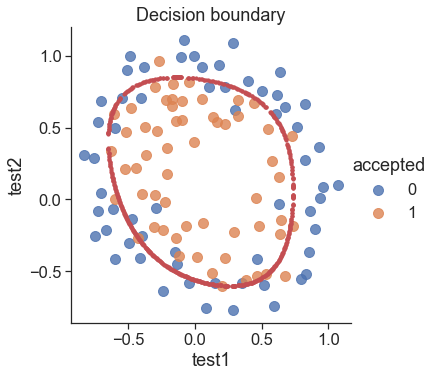

In [41]:
draw_boundary(power=6, lambd=1)#lambda=1

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


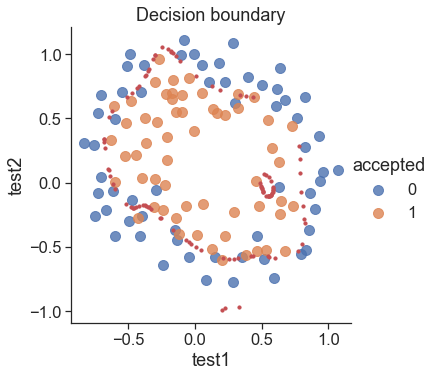

In [42]:
draw_boundary(power=6, lambd=0)  # no regularization, over fitting，#lambda=0,没有正则化，过拟合了

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


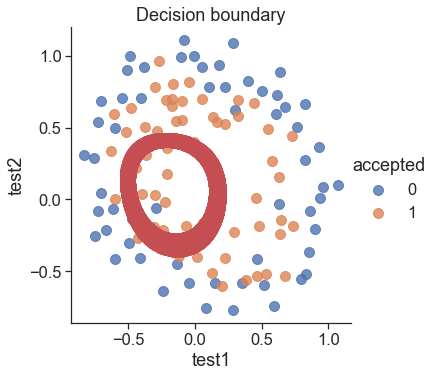

In [43]:
draw_boundary(power=6, lambd=100)  # underfitting，#lambda=100,欠拟合

2.8节延续2.7节向我们展示了恰当拟合、过拟合与欠拟合的情况。

### 祝贺！你已完成本次作业！